In [1]:
import numpy as np
import random
import json
import os
import shutil
import glob
import matplotlib.pyplot as plt

In [2]:
dirs = ['00', '01', '02', '03', '04', '05', '06']
for d in dirs:
    files = os.listdir(f'./data/{d}')
    pairs = []
    for i in range(len(files) - 1):
        nextt = i + 1
        val = ' '.join([d+'/'+files[i], d+'/'+files[nextt]])
        pairs.append(val)
    with open(f"./data/{d}.txt", 'w') as fr:
        for p in pairs:
            fr.write(p)
            fr.write('\n')

In [2]:
all_categories = {'bed':0, 'table':1, 'sofa':2, 'chair':3, 'desk':4}

original data format: {"centers": [[3.275721311569214, 5.9295573234558105, -1.2045506238937378], [6.004755973815918, -2.78536057472229, -0.976753830909729]], "nodes": [0, 0], "pose": [0.9999796, 0.001566466]}

our data format: {"centers": [], "nodes": [], "scene": scene_id}

In [17]:
# TODO - Change the parameters according to Votenet output
NUM_CATEGORY = 5
CATEGORY = np.arange(0, NUM_CATEGORY)
OBJECTS_RANGE = {0: (0, 1), 1: (0, 3), 2: (0, 2), 3: (4, 7), 4: (0, 3), 5: (4, 6), 6: (3, 5), 7: (2, 3), 8: (2, 4), 9: (0, 1)}
OBJECT_DISTANCE_DICT = {0: (0.5, 0.8), 1: (0.4, 0.4), 2: (0.3, 0.7), 3: (0.3, 0.3), 4: (0.3, 0.3), 5:(0.5, 0.7), 6:(0.2, 0.2), 7:(0.2, 0.2), 8:(0.2, 0.4), 9:(0.3, 0.8)}
OBJECT_X_RANGE_DICT = {0: (-10, 10), 1: (-10, 10), 2: (-10, 10), 3:(-10, 10), 4:(-10, 10), 5:(-10, 10), 6:(-10, 10), 7:(-10, 10), 8:(-10, 10), 9:(-10, 10)}
OBJECT_Y_RANGE_DICT = {0: (-10, 10), 1: (-10, 10), 2: (-10, 10), 3:(-10, 10), 4:(-10, 10), 5:(-10, 10), 6:(-10, 10), 7:(-10, 10), 8:(-10, 10), 9:(-10, 10)}
OBJECT_Z_RANGE_DICT = {0: (-0.5, -0.1), 1: (-0.5, -0.1), 2: (-0.5, -0.1), 3:(-0.5, -0.1), 4:(-0.5, -0.1), 5: (0.4, 0.5), 6: (1.1, 1.2), 7: (0.4, 0.5), 8: (1.1, 1.2), 9: (0.4, 0.5) }
SAVE_VIS = True
ADD_MODE = False # If not in add mode, erase current data

In [ ]:
# info = {}
# with open('category.json', 'r') as fread:
#     info = json.load(fread)

In [7]:
# Generate a specific object while keeping certain distance away from all existing objects
# In case a free space cannot be found, return None
def XYZ_Generation(existing_objects, existing_nodes, curr_obj):
    free = False
    num_generation = 0
    while not free:
        x = np.random.uniform(low=OBJECT_X_RANGE_DICT[curr_obj][0], high=OBJECT_X_RANGE_DICT[curr_obj][1], size=(1))[0]
        count = 0
        num_generation += 1
        if num_generation > 1000:
            print("Couldn't find a value...returning")
            return None
        for (i, obj) in enumerate(existing_objects):
            dist = OBJECT_DISTANCE_DICT[existing_nodes[i]]
            dist2 = OBJECT_DISTANCE_DICT[curr_obj]
            if x <= obj[0] - dist[0] - dist2[0] or x >= obj[0] + dist[0] + dist2[0]:
                count += 1
            else:
                break
        if (count == len(existing_objects)):
            free = True 
    free = False
    num_generation = 0
    while not free:
        y = np.random.uniform(low=OBJECT_Y_RANGE_DICT[curr_obj][0], high=OBJECT_Y_RANGE_DICT[curr_obj][1], size=(1))[0]
        count = 0
        num_generation += 1
        if num_generation > 1000:
            print("Couldn't find a value...returning")
            return None
        for (i, obj) in enumerate(existing_objects):
            dist = OBJECT_DISTANCE_DICT[existing_nodes[i]]
            dist2 = OBJECT_DISTANCE_DICT[curr_obj]
            if y <= obj[1] - dist[1] - dist2[1] or y >= obj[1] + dist[1] + dist2[1]:
                count += 1
            else:
                break
        if (count == len(existing_objects)):
            free = True
#     print(x, y)
    z = np.random.uniform(low=OBJECT_Z_RANGE_DICT[curr_obj][0], high=OBJECT_Z_RANGE_DICT[curr_obj][1], size=(1))[0]
    return [x, y, z]
        

In [12]:
# Generate a scene containing all possible objects
def scene_generation(compo):
    object_number_list = []
    for obj in compo.keys():
        num = np.random.randint(compo[obj][0], compo[obj][1])
        object_number_list.append(num)
    print(object_number_list)
    existing_objects = []
    existing_nodes = []
    for (i, num) in enumerate(object_number_list):
        for j in range(num):
            # Make sure objects are separated by some distance
            curr_centers = XYZ_Generation(existing_objects, existing_nodes, i)
            if curr_centers is None:
                print("Skipping this node..")
                continue
            curr_centers = np.asarray(curr_centers)
            existing_objects.append(curr_centers)
            existing_nodes.append(i)
    assert len(existing_objects) == len(existing_nodes)
    return np.asarray(existing_objects, dtype=object), np.asarray(existing_nodes)
        

In [9]:
# res1, res2 = scene_generation()
# assert res1.shape[0] == res2.shape[0]

[1, 0, 2, 4, 1]


In [ ]:
# Need this?
# def random_permute(a, b):    
#     assert len(a) == len(b)
#     p = numpy.random.permutation(len(a))
#     return a[p], b[p]

## Augmentation methods

In [10]:
# randomly delete some objects
def random_delete(object_centers, object_nodes, num_delete=3):
    delete_index = np.random.randint(0, object_centers.shape[0], num_delete)
    centers = np.delete(object_centers, delete_index, axis=0)
    nodes = np.delete(object_nodes, delete_index)
    assert centers.shape[0] == nodes.shape[0]
    return centers, nodes

# add gaussian noise
# but have to keep objects within x y range
def random_noise(object_centers, nodes, noise_std=1):
    noises = [np.random.normal(0,0.5,3) for i in range(object_centers.shape[0])]
    new_centers = []
    for (i, noise) in enumerate(noises):
        noise_x = noise[0]
        noise_y = noise[1]
        noise_z = noise[2]
        x = object_centers[i][0]
        y = object_centers[i][1]
        z = object_centers[i][2]
        if x + noise_x >= OBJECT_X_RANGE_DICT[nodes[i]][0] and x + noise_x <= OBJECT_X_RANGE_DICT[nodes[i]][1]:
#             print("Added noise to x")
            x += noise_x
        if y + noise_y >= OBJECT_Y_RANGE_DICT[nodes[i]][0] and y + noise_y <= OBJECT_Y_RANGE_DICT[nodes[i]][1]:
#             print("Added noise to y")
            y += noise_y
        if z + noise_z >= OBJECT_Z_RANGE_DICT[nodes[i]][0] and z + noise_z <= OBJECT_Z_RANGE_DICT[nodes[i]][1]:
#             print("Added noise to z")
            z += noise_z
        new_centers.append(np.array([x,y,z]))
    new_centers = np.asarray(new_centers)
    assert new_centers.shape == object_centers.shape
    return new_centers
    

In [14]:
def save_scene(object_center, object_nodes, id_, save_name):
    info = {'centers': object_center.tolist(), 'nodes': object_nodes.tolist(), 'scene': id_}
    with open(save_name, 'w') as fw:
        json.dump(info, fw, indent=4)

In [11]:
def save_visualization(objs, nodes, colors, save_name):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
#     colors = [tuple(np.random.random(size=3) * 256) for i in range(NUM_CATEGORY)]
    for i in range(NUM_CATEGORY):
        obj = objs[nodes == i]
        if len(obj) == 0:
            continue
        xs = obj[:, 0]
        ys = obj[:, 1]
        zs = obj[:, 2]
        ax.scatter(xs, ys, zs, color=colors[i])
    #plt.show()
    plt.savefig(save_name, dpi=100)

[0, 0, 0, 5, 0]
[0, 0, 0, 5, 0]
[0, 0, 0, 5, 0]
[0, 0, 0, 4, 0]
[0, 0, 0, 3, 0]
[0, 0, 0, 5, 0]
[0, 0, 0, 3, 0]
[0, 0, 0, 3, 0]
[0, 0, 0, 5, 0]
[0, 0, 0, 5, 0]
[0, 0, 0, 3, 0]
[0, 0, 0, 3, 0]
[0, 0, 0, 5, 0]
[0, 0, 0, 3, 0]
[0, 0, 0, 4, 0]
[0, 0, 0, 4, 0]
[0, 0, 0, 5, 0]
[0, 0, 0, 3, 0]
[0, 0, 0, 4, 0]
[0, 0, 0, 5, 0]
[0, 0, 0, 3, 0]
[0, 0, 0, 4, 0]
[0, 0, 0, 4, 0]
[0, 0, 0, 5, 0]
[0, 0, 0, 5, 0]
[0, 0, 0, 3, 0]
[0, 0, 0, 3, 0]
[0, 0, 0, 5, 0]
[0, 0, 0, 5, 0]
[0, 0, 0, 3, 0]
[0, 0, 0, 3, 0]
[0, 0, 0, 4, 0]
[0, 0, 0, 5, 0]
[0, 0, 0, 5, 0]
[0, 0, 0, 3, 0]
[0, 0, 0, 5, 0]
[0, 0, 0, 3, 0]
[0, 0, 0, 5, 0]
[0, 0, 0, 5, 0]
[0, 0, 0, 4, 0]
[0, 0, 0, 3, 0]
[0, 0, 0, 3, 0]
[0, 0, 0, 4, 0]
[0, 0, 0, 3, 0]
[0, 0, 0, 4, 0]
[0, 0, 0, 4, 0]
[0, 0, 0, 4, 0]
[0, 0, 0, 4, 0]
[0, 0, 0, 3, 0]
[0, 0, 0, 3, 0]
[0, 0, 0, 5, 0]
[0, 0, 0, 5, 0]
[0, 0, 0, 4, 0]
[0, 0, 0, 3, 0]
[0, 0, 0, 3, 0]
[0, 0, 0, 4, 0]
[0, 0, 0, 4, 0]
[0, 0, 0, 3, 0]
[0, 0, 0, 5, 0]
[0, 0, 0, 3, 0]
[0, 0, 0, 5, 0]
[0, 0, 0, 3, 0]
[0, 0, 0

[0, 1, 0, 8, 0]
[0, 1, 0, 4, 0]
[0, 1, 0, 6, 0]
[0, 1, 0, 6, 0]
[0, 1, 0, 9, 0]
[0, 1, 0, 8, 0]
[0, 1, 0, 6, 0]
[0, 1, 0, 7, 0]
[0, 1, 0, 8, 0]
[0, 1, 0, 4, 0]
[0, 1, 0, 9, 0]
[0, 1, 0, 4, 0]
[0, 1, 0, 4, 0]
[0, 1, 0, 9, 0]
[0, 1, 0, 5, 0]
[0, 1, 0, 7, 0]
[0, 1, 0, 7, 0]
[0, 1, 0, 6, 0]
[0, 1, 0, 4, 0]
[0, 1, 0, 6, 0]
[0, 1, 0, 7, 0]
[0, 1, 0, 6, 0]
[0, 1, 0, 5, 0]
[0, 1, 0, 5, 0]
[0, 1, 0, 7, 0]
[0, 1, 0, 5, 0]
[0, 1, 0, 6, 0]
[0, 1, 0, 4, 0]
[0, 1, 0, 8, 0]
[0, 1, 0, 8, 0]
[0, 1, 0, 8, 0]
[0, 1, 0, 6, 0]
[0, 1, 0, 8, 0]
[0, 1, 0, 7, 0]
[0, 1, 0, 7, 0]
[0, 1, 0, 6, 0]
[0, 1, 0, 9, 0]
[0, 1, 0, 9, 0]
[0, 1, 0, 6, 0]
[0, 1, 0, 5, 0]
[0, 1, 0, 9, 0]
[0, 1, 0, 5, 0]
[0, 1, 0, 5, 0]
[0, 1, 0, 4, 0]
[0, 1, 0, 7, 0]
[0, 1, 0, 7, 0]
[0, 1, 0, 6, 0]
[0, 1, 0, 4, 0]
[0, 1, 0, 7, 0]
[0, 1, 0, 5, 0]
[0, 1, 0, 8, 0]
[0, 1, 0, 4, 0]
[0, 1, 0, 7, 0]
[0, 1, 0, 9, 0]
[0, 1, 0, 5, 0]
[0, 1, 0, 9, 0]
[0, 1, 0, 9, 0]
[0, 1, 0, 8, 0]
[0, 1, 0, 5, 0]
[0, 1, 0, 5, 0]
[0, 1, 0, 6, 0]
[0, 1, 0, 7, 0]
[0, 1, 0

[0, 0, 0, 2, 1]
[0, 0, 1, 2, 2]
[0, 0, 0, 2, 1]
[0, 0, 0, 4, 1]
[0, 0, 1, 2, 2]
[0, 0, 1, 2, 1]
[0, 0, 1, 2, 1]
[0, 0, 1, 4, 1]
[0, 0, 0, 4, 2]
[0, 0, 1, 3, 2]
[0, 0, 1, 3, 2]
[0, 0, 0, 3, 1]
[0, 0, 0, 3, 2]
[0, 0, 1, 3, 1]
[0, 0, 0, 3, 1]
[0, 0, 0, 4, 1]
[0, 0, 1, 2, 2]
[0, 0, 1, 3, 1]
[0, 0, 0, 2, 1]
[0, 0, 0, 3, 1]
[0, 0, 1, 2, 2]
[0, 0, 1, 2, 2]
[0, 0, 1, 3, 2]
[0, 0, 0, 3, 2]
[0, 0, 0, 2, 2]
[0, 0, 0, 2, 2]
[0, 0, 0, 3, 2]
[0, 0, 0, 2, 1]
[0, 0, 1, 4, 1]
[0, 0, 0, 2, 2]
[0, 0, 0, 2, 2]
[0, 0, 1, 4, 1]
[0, 0, 1, 4, 2]
[0, 0, 0, 3, 2]
[0, 0, 1, 4, 1]
[0, 0, 0, 4, 1]
[0, 0, 0, 4, 1]
[0, 0, 1, 2, 2]
[0, 0, 1, 2, 2]
[0, 0, 0, 4, 1]
[0, 0, 0, 2, 1]
[0, 0, 1, 2, 2]
[0, 0, 0, 3, 2]
[0, 0, 1, 4, 2]
[0, 0, 1, 4, 1]
[0, 0, 1, 4, 1]
[0, 0, 0, 4, 2]
[0, 0, 0, 3, 2]
[0, 0, 1, 3, 2]
[0, 0, 0, 2, 1]
[0, 0, 1, 4, 1]
[0, 0, 1, 2, 1]
[0, 0, 0, 4, 2]
[0, 0, 0, 3, 2]
[0, 0, 0, 2, 1]
[0, 0, 1, 4, 2]
[0, 0, 0, 3, 1]
[0, 0, 0, 2, 2]
[0, 0, 1, 3, 1]
[0, 0, 1, 2, 2]
[0, 0, 1, 4, 2]
[0, 0, 0, 2, 2]
[0, 0, 0

[0, 0, 0, 0, 5]
[0, 0, 0, 0, 3]
[0, 0, 0, 1, 3]
[0, 0, 0, 0, 5]
[0, 0, 0, 1, 3]
[0, 0, 0, 1, 3]
[0, 0, 0, 1, 5]
[0, 0, 0, 0, 3]
[0, 0, 0, 1, 4]
[0, 0, 0, 1, 6]
[0, 0, 0, 1, 5]
[0, 0, 0, 0, 4]
[0, 0, 0, 1, 4]
[0, 0, 0, 0, 4]
[0, 0, 0, 1, 3]
[0, 0, 0, 0, 6]
[0, 0, 0, 1, 5]
[0, 0, 0, 1, 4]
[0, 0, 0, 0, 6]
[0, 0, 0, 1, 6]
[0, 0, 0, 0, 3]
[0, 0, 0, 0, 4]
[0, 0, 0, 1, 3]
[0, 0, 0, 1, 4]
[0, 0, 0, 1, 6]
[0, 0, 0, 1, 3]
[0, 0, 0, 0, 4]
[0, 0, 0, 1, 6]
[0, 0, 0, 1, 6]
[0, 0, 0, 0, 4]
[0, 0, 0, 0, 5]
[0, 0, 0, 0, 5]
[0, 0, 0, 1, 6]
[0, 0, 0, 0, 5]
[0, 0, 0, 0, 6]
[0, 0, 0, 0, 6]
[0, 0, 0, 1, 3]
[0, 0, 0, 0, 4]
[0, 0, 0, 0, 3]
[0, 0, 0, 1, 5]
[0, 0, 0, 1, 6]
[0, 0, 0, 1, 4]
[0, 0, 0, 0, 6]
[0, 0, 0, 1, 5]
[0, 0, 0, 1, 5]
[0, 0, 0, 1, 3]
[0, 0, 0, 0, 4]
[0, 0, 0, 0, 5]
[0, 0, 0, 0, 3]
[0, 0, 0, 0, 5]
[0, 0, 0, 1, 3]
[0, 0, 0, 1, 6]
[0, 0, 0, 1, 3]
[0, 0, 0, 1, 3]
[0, 0, 0, 1, 5]
[0, 0, 0, 1, 5]
[0, 0, 0, 1, 6]
[0, 0, 0, 1, 6]
[0, 0, 0, 0, 6]
[0, 0, 0, 1, 5]
[0, 0, 0, 1, 5]
[0, 0, 0, 1, 5]
[0, 0, 0

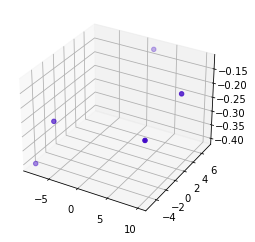

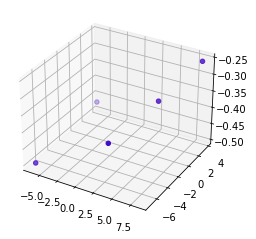

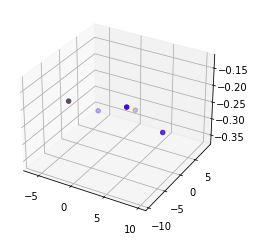

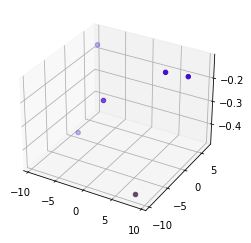

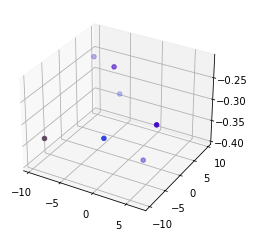

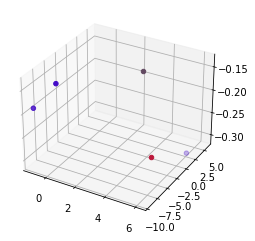

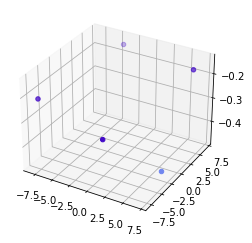

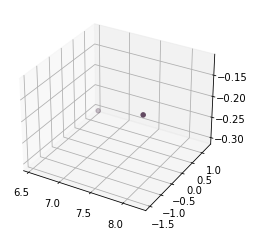

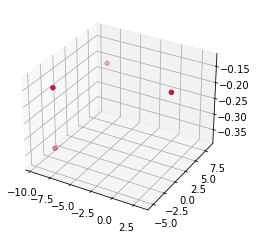

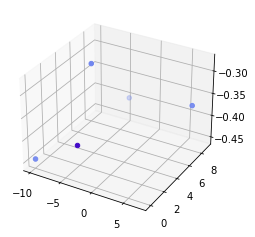

In [18]:
iteration = 1000
num_augment = 2
num_noise = 2
scene_id = 0
count = 0
#all_categories = {'bed':0, 'table':1, 'sofa':2, 'chair':3, 'desk':4}
hardcode = [
    {0: [0,1], 1: [0,1], 2: [0,1], 3: [3,6], 4: [0,1]}, # a few chairs
    {0: [0,1], 1: [0,1], 2: [0,1], 3: [5,10], 4: [0,1]}, # many chairs
    {0: [0,1], 1: [1,3], 2: [0,1], 3: [2,5], 4: [0,1]}, # a few tables and a few chairs
    {0: [0,1], 1: [1,2], 2: [0,1], 3: [4,10], 4: [0,1]}, # one table and many chairs
    {0: [1,3], 1: [0,2], 2: [0,1], 3: [0,5], 4: [0,1]}, # a few bed and some chairs
    {0: [0,1], 1: [0,2], 2: [1,4], 3: [0,5], 4: [0,1]}, # a few sofa and some chairs
    {0: [0,1], 1: [0,1], 2: [0,2], 3: [2,5], 4: [1,3]}, # a few desk and some chairs
    {0: [0,1], 1: [2,5], 2: [0,1], 3: [0,2], 4: [0,1]}, # many tables
    {0: [0,1], 1: [0,1], 2: [2,6], 3: [0,2], 4: [0,1]}, # many sofas
    {0: [0,1], 1: [0,1], 2: [0,1], 3: [0,2], 4: [3,7]} # many desks
]

colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
          for i in range(NUM_CATEGORY)]
if not os.path.exists('visualization'):
    os.mkdir('visualization')
# if not ADD_MODE:
#     if os.path.exists('./synthetic'):
#         shutil.rmtree('synthetic')
#     os.makedirs('synthetic/visualization', exist_ok=True)
# else:
#     scene_id = len(list(glob.glob('./synthetic/*.png')))
# Every graph in each iteration should be 'similar'
for compo in hardcode:
    for i in range(200):
        basic_scene, nodes = scene_generation(compo)
        if i == 0 and SAVE_VIS:
            save_visualization(basic_scene, nodes, colors, f'./visualization/{scene_id}_{i}.png')
        save_scene(basic_scene, nodes, scene_id, f'./data/{count}.json')
        count += 1
    scene_id += 1
    